In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

**Sample Data Generation**

In [43]:
def apply_sine_function(column, a, b):
  return a + b*np.sin(column)

# n     = num of nodes (0 to n-1 inclusive)
# t     = num of timesteps (0 to t inclusive)
# alpha = percentage of edges that have sin functions, the rest are zero edges (not deleted)
# seed  = seed number used for randomization sin functions and their distribution in the graph
def generate_graph_vals(n=10, t=1000, alpha=0.4, seed=123):
  np.random.seed(seed)
  num_edges = int(n**2)
  ### PREP RNG - requires: n, alpha, seed ###
  random.seed(seed)

  ### EXCLUDE VALUES: prevents values assigned to self loops
  exclude = np.array([(i*n + i) for i in range(n)])
  sin_edges = np.random.choice(np.setdiff1d(np.arange(num_edges), exclude), size=int(num_edges*alpha), replace=False)

  ### SET VALUES FOR EACH TIME STEP - requires: n, t, sin_edges ###
  vals = np.zeros(shape=(t, num_edges))
  vals[:,sin_edges] = np.tile(np.arange(t), (len(sin_edges), 1)).T

  a = np.random.uniform(-10,10,len(sin_edges))
  b = np.random.uniform(-10,10,len(sin_edges))

  vals[:,sin_edges] = apply_sine_function(vals[:,sin_edges], a, b)

  return vals

# vals = generate_graph_vals(100,1000)

In [67]:
### given the list of vals (num_edges x timesteps), return new data with line graph partitions concatenated
def add_partitions(v_list):

    in_in_list = []
    out_out_list = []
    in_out_list = []
    n = int(np.sqrt(len(v_list[0])))

    for v in v_list:
        #convert the vector back to matrix form
        m = np.reshape(v,(n,n))

        in_in = np.zeros(m.shape)
        out_out = np.zeros(m.shape)
        in_out = np.zeros(m.shape)

        for i in range(n):
            for j in range(n):
                in_in[i][j] = (np.sum(m[:,j]) - m[i][j])
                out_out[i][j] = (np.sum(m[i]) - m[i][j])
                in_out[i][j] = (np.sum(m) - in_in[i][j] - out_out[i][j] - m[i][j])

        in_in_list.append(in_in.reshape(n**2))
        out_out_list.append(out_out.reshape(n**2))
        in_out_list.append(in_out.reshape(n**2))

    return np.concatenate((v_list, in_in_list, out_out_list, in_out_list))
    

    

In [ ]:
# def get_partitions(v):
#     #convert the vector back to matrix form
#     n = int(np.sqrt(len(v)))
#     m = np.reshape(v,(n,n))

#     idx = np.arange(0, n)

#     in_in = np.zeros(m.shape)
#     out_out = np.zeros(m.shape)
#     in_out = np.zeros(m.shape)

#     in_in += (np.sum(m[:,idx]) - m)
#     out_out += (np.sum(m[idx]) - m)
#     in_out += (np.sum(m) - in_in - out_out - m)

#     return in_in, out_out, in_out
    
# in_in, out_out, in_out = get_partitions(vals[0])

# in_out

In [49]:
# currently only supports a complete graph (uses edge count to calculate node count)
# vals = an ndarray with dimensions (time, edge_index) to get an edge weight
def setup_graphs(vals):

  ### Recover Node Count ###
  n = int(1/2 + np.sqrt(1 + 4*vals.shape[1])/2)
  if vals.shape[1] != n*(n-1):
    print("The values given do not form a complete graph: this logic has not been implemented.")

  ### SET UP ONE GRAPH FOR EACH TIME STEP - requires: n, t, vals ###
  graphs = []
  for time in range(vals.shape[0]):
    G = nx.complete_graph(n, nx.DiGraph())
    edge_index = 0
    for (start, end) in G.edges:
      G.add_edge(start, end, index=edge_index, weight=vals[time, edge_index])
      edge_index += 1
    graphs.append(G)

  return graphs

**Logic For Generating / Accessing ETV Graphs**
(Edge-to-Vertex)

In [11]:
### THE DYNAMIC ACCESS OF ETV NODES GIVEN A PRIMAL EDGE ###

def get_ETV_node(primal_G, edge_index):
  edge = list(primal_G.edges)[edge_index] # Unpacking the entire edge list may be slowing it down
  node_data = {'edge': (edge[0], edge[1]), 'weight': primal_G.get_edge_data(edge[0], edge[1])['weight']}
  return (edge_index, node_data)

In [12]:
### a helper function for get_ETV_edges() to reduce code duplication ###

# Does not support self-loops neighboring themselves (would it be an in-out relation only?)
def make_ETV_edge(node, edge_1, edge_2, neighbor_type):

  ### logic for self-loops ###
  if edge_1 == edge_2:
    return {}

  ### Order the edge indexes in-order ###
  # elif edge_1 < edge_2:
  #   edge_name = (edge_1, edge_2)
  # else:
  #   edge_name = (edge_2, edge_1)

  edge_name = (edge_1, edge_2)

  return {edge_name: {'primal_node': node, 'type': neighbor_type}}

In [13]:
### THE DYNAMIC ACCESS OF ETV EDGES GIVEN A PRIMAL NODE ###

def get_ETV_edges(primal_G, node):
  ETV_edges = {}

  ### Each node in the primal becomes an edge in the ETVs according to the direction the edges face eachother ###
  for (start_1, end_1, attr_1) in primal_G.in_edges(node, data=True):
    for (start_2, end_2, attr_2) in primal_G.in_edges(node, data=True):
      ETV_edges |= make_ETV_edge(node, attr_1['index'], attr_2['index'], 'in-in')
    for (start_2, end_2, attr_2) in primal_G.out_edges(node, data=True):
      ETV_edges |= make_ETV_edge(node, attr_1['index'], attr_2['index'], 'in-out')
  for (start_1, end_1, attr_1) in primal_G.out_edges(node, data=True):
    for (start_2, end_2, attr_2) in primal_G.out_edges(node, data=True):
      ETV_edges |= make_ETV_edge(node, attr_1['index'], attr_2['index'], 'out-out')

  return ETV_edges

In [14]:
### THE STATIC MAKE-ENTIRE-ETV GIVEN A PRIMAL GRAPH ###
# uses the dynamic methods to reduce code duplication, but returns the entire ETV graph

def create_ETV_graphs(primal_G_list):

  ETV_list = []

  for primal_G in primal_G_list: # one for each timestep

    ### Create new undirected ETV graphs ##
    ETV_G = nx.MultiGraph()

    ### Each edge in the primal becomes a node in the ETV graphs ###
    for edge_index in range(len(primal_G.edges)):
      node, node_data = get_ETV_node(primal_G, edge_index)
      ETV_G.add_node(node, **node_data)

    ### Each node in the primal becomes an edge in the ETVs according to the direction the edges face eachother ###
    for node in primal_G.nodes:
      ETV_edges = get_ETV_edges(primal_G, node)
      for edge_name in ETV_edges.keys():
        ETV_G.add_edge(*edge_name, **ETV_edges[edge_name])

    ### Save the ETV graphs from this timestep ###
    ETV_list.append(ETV_G)

  return ETV_list

**Printing and Display Functions**

In [15]:
def show_graph(graph):
  nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, font_size=12, arrows=True)

In [16]:
def print_graph_data(graph):
  for node, data in graph.nodes(data=True):
    print(f"The data of node {node} is {data}")
  for start, end, data in graph.edges(data=True):
    print(f"The data of edge ({start}, {end}) is {data}")

In [17]:
def print_ETV_data_dynamic(primal_G):
  for edge_index in range(len(primal_G.edges)):
    node, node_data = get_ETV_node(primal_G, edge_index)
    print(f"The data of node {node} is {node_data}")

  for node in primal_G.nodes:
    ETV_edges = get_ETV_edges(primal_G, node)
    for edge_name in ETV_edges.keys():
      print(f"The data of edge {edge_name} is {ETV_edges[edge_name]}")

**Playground**

In [18]:
# Generates an instance and saves weights to file array.txt
vals = generate_graph_vals(n=3, t=2, alpha=0.4, seed=0)
np.savetxt('./array.txt', vals)
primal_g_list = setup_graphs(vals)
ETV_list = create_ETV_graphs(primal_g_list)

In [19]:
# Print the nodes and edges of the primal graph
print_graph_data(primal_g_list[0])

The data of node 0 is {}
The data of node 1 is {}
The data of node 2 is {}
The data of edge (0, 1) is {'index': 0, 'weight': 0.0}
The data of edge (0, 2) is {'index': 1, 'weight': 0.0}
The data of edge (1, 0) is {'index': 2, 'weight': 0.0}
The data of edge (1, 2) is {'index': 3, 'weight': -9.190312436384449}
The data of edge (2, 0) is {'index': 4, 'weight': 0.0}
The data of edge (2, 1) is {'index': 5, 'weight': -0.28144606874374745}


In [20]:
# Print the nodes and edges of the static ETV graph
print_graph_data(ETV_list[0])

The data of node 0 is {'edge': (0, 1), 'weight': 0.0}
The data of node 1 is {'edge': (0, 2), 'weight': 0.0}
The data of node 2 is {'edge': (1, 0), 'weight': 0.0}
The data of node 3 is {'edge': (1, 2), 'weight': -9.190312436384449}
The data of node 4 is {'edge': (2, 0), 'weight': 0.0}
The data of node 5 is {'edge': (2, 1), 'weight': -0.28144606874374745}
The data of edge (0, 2) is {'primal_node': 0, 'type': 'in-out'}
The data of edge (0, 2) is {'primal_node': 1, 'type': 'in-out'}
The data of edge (0, 4) is {'primal_node': 0, 'type': 'in-out'}
The data of edge (0, 1) is {'primal_node': 0, 'type': 'out-out'}
The data of edge (0, 1) is {'primal_node': 0, 'type': 'out-out'}
The data of edge (0, 5) is {'primal_node': 1, 'type': 'in-in'}
The data of edge (0, 5) is {'primal_node': 1, 'type': 'in-in'}
The data of edge (0, 3) is {'primal_node': 1, 'type': 'in-out'}
The data of edge (1, 2) is {'primal_node': 0, 'type': 'in-out'}
The data of edge (1, 4) is {'primal_node': 0, 'type': 'in-out'}
The 

In [21]:
# Print the nodes and edges of the dynamic ETV graph as they are generated
print_ETV_data_dynamic(primal_g_list[0])

The data of node 0 is {'edge': (0, 1), 'weight': 0.0}
The data of node 1 is {'edge': (0, 2), 'weight': 0.0}
The data of node 2 is {'edge': (1, 0), 'weight': 0.0}
The data of node 3 is {'edge': (1, 2), 'weight': -9.190312436384449}
The data of node 4 is {'edge': (2, 0), 'weight': 0.0}
The data of node 5 is {'edge': (2, 1), 'weight': -0.28144606874374745}
The data of edge (2, 4) is {'primal_node': 0, 'type': 'in-in'}
The data of edge (2, 0) is {'primal_node': 0, 'type': 'in-out'}
The data of edge (2, 1) is {'primal_node': 0, 'type': 'in-out'}
The data of edge (4, 2) is {'primal_node': 0, 'type': 'in-in'}
The data of edge (4, 0) is {'primal_node': 0, 'type': 'in-out'}
The data of edge (4, 1) is {'primal_node': 0, 'type': 'in-out'}
The data of edge (0, 1) is {'primal_node': 0, 'type': 'out-out'}
The data of edge (1, 0) is {'primal_node': 0, 'type': 'out-out'}
The data of edge (0, 5) is {'primal_node': 1, 'type': 'in-in'}
The data of edge (0, 2) is {'primal_node': 1, 'type': 'in-out'}
The d

{(2, 4): {'primal_node': 0, 'type': 'in-in'}, (2, 0): {'primal_node': 0, 'type': 'in-out'}, (2, 1): {'primal_node': 0, 'type': 'in-out'}, (4, 2): {'primal_node': 0, 'type': 'in-in'}, (4, 0): {'primal_node': 0, 'type': 'in-out'}, (4, 1): {'primal_node': 0, 'type': 'in-out'}, (0, 1): {'primal_node': 0, 'type': 'out-out'}, (1, 0): {'primal_node': 0, 'type': 'out-out'}}
{(0, 5): {'primal_node': 1, 'type': 'in-in'}, (0, 2): {'primal_node': 1, 'type': 'in-out'}, (0, 3): {'primal_node': 1, 'type': 'in-out'}, (5, 0): {'primal_node': 1, 'type': 'in-in'}, (5, 2): {'primal_node': 1, 'type': 'in-out'}, (5, 3): {'primal_node': 1, 'type': 'in-out'}, (2, 3): {'primal_node': 1, 'type': 'out-out'}, (3, 2): {'primal_node': 1, 'type': 'out-out'}}


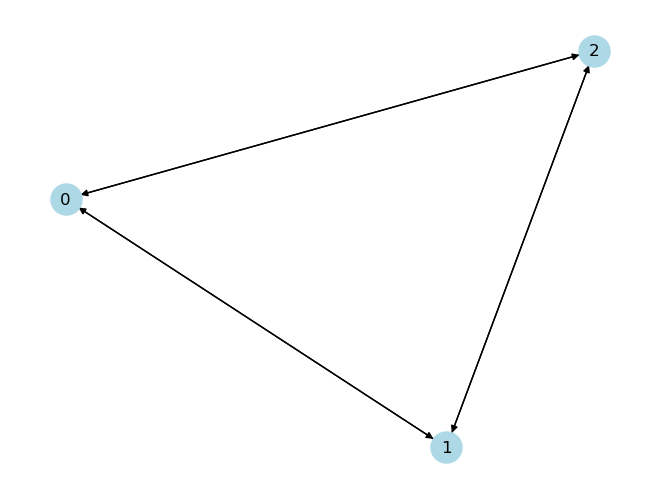

In [22]:
show_graph(primal_g_list[0])
print(get_ETV_edges(primal_g_list[0], 0))
print(get_ETV_edges(primal_g_list[0], 1))

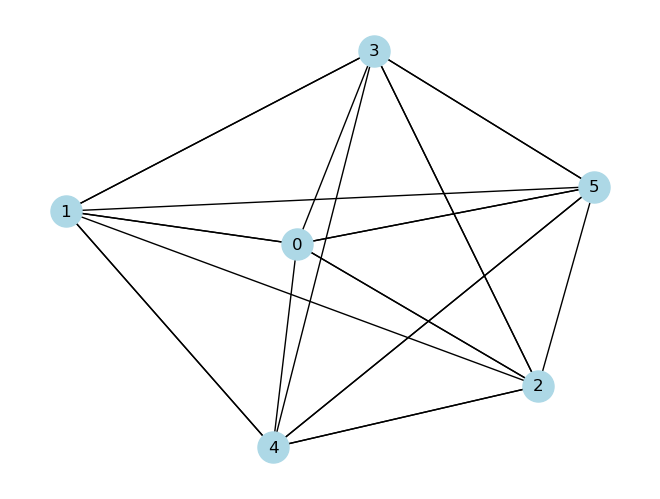

In [23]:
show_graph(ETV_list[0])

**The Trash Bin**

In [24]:
### a practically useless function, this makes the entire graph and does a lot of duplicate work along the way ###

def get_ETV_edges_all(primal_G):
  ETV_edges = {}

  for (start_1, end_1, attr_1) in primal_G.edges(data=True):
    for (start_2, end_2, attr_2) in primal_G.edges(data=True):
      if end_1 == end_2:
        ETV_edges |= make_ETV_edge(end_1,   attr_1['index'], attr_2['index'], 'in-in')
      if end_1 == start_2:
        ETV_edges |= make_ETV_edge(end_1,   attr_1['index'], attr_2['index'], 'in-out')
      if start_1 == end_2:
        ETV_edges |= make_ETV_edge(end_2,   attr_1['index'], attr_2['index'], 'in-out')
      if start_1 == start_2:
        ETV_edges |= make_ETV_edge(start_1, attr_1['index'], attr_2['index'], 'out-out')

  return ETV_edges

### Just learn

In [25]:
# update matrix helper function
# mat is matrix that is being updated
# e1 and e2 are the edges of which we are adding the values to
# w1 and w2 are the weights of those edges
# both is a boolean if we need to add both to the matrix

def update_mat(mat, e1, e2, w1, w2, both):
    mat[e1]+= w2
    if both:
        mat[e2] += w1
    return

In [168]:
# function to get summation of neighboring values
# formula for each node: v1(sum of neighbors values)
# v1 is orignial value of the node we are finding value of, in order to prevent O value edges from having values
# place new values in original adjacency matrix for all three types, in-in, out-out, in-out


def get_partitions(primal_g):

    num_nodes = primal_g.number_of_nodes()
    in_in_mat = np.zeros((num_nodes, num_nodes))
    out_out_mat = np.zeros((num_nodes, num_nodes))
    in_out_mat = np.zeros((num_nodes, num_nodes))

    for p_node in primal_g.nodes():
        ETV_edges = get_ETV_edges(primal_g, p_node)

        for key, value in ETV_edges.items():
            id1, node1_val = get_ETV_node(primal_g, key[0])
            id2, node2_val = get_ETV_node(primal_g, key[1])

            edge1 = node1_val['edge']
            edge2 = node2_val['edge']
            w1 = node1_val['weight']
            w2 = node2_val['weight']

            if value['type'] == 'in-out':
                if edge1 == (edge2[1], edge2[0]):
                    update_mat(in_out_mat, edge1, edge2, w1, w2, both = False)
                else:
                    update_mat(in_out_mat, edge1, edge2, w1, w2, both = True)
            
            elif value['type'] == 'in-in':
                update_mat(in_in_mat, edge1, edge2, w1, w2, both = True)

            elif value['type'] == 'out-out':
                update_mat(out_out_mat, edge1, edge2, w1, w2, both = True)


    return in_in_mat, out_out_mat, in_out_mat

in_in, out_out, in_out = get_partitions(primal_g_list[0])

TypeError: 'dict_items' object is not subscriptable

In [68]:
num_nodes = 100
timesteps = 5
alpha = .4
random_seed = 42

vals = generate_graph_vals(num_nodes, timesteps, alpha, random_seed)
lg_vals = add_partitions(vals)


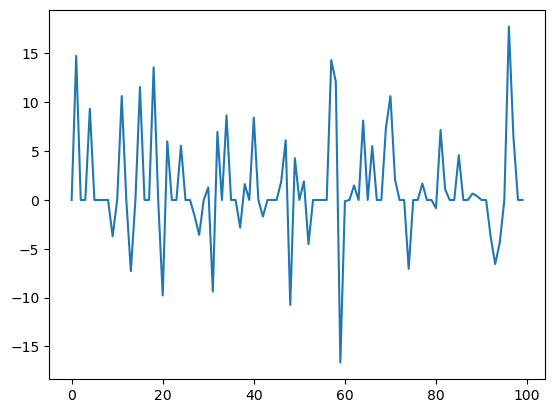

In [74]:
plt.plot(lg_vals[1, :][:100])

In [166]:
# LG_list = np.array([np.array(get_partitions(G_list[i])) for i in range(len(G_list))])
# get_partitions(G_list[0])
# print(len(G_list))
# LG_list.shape



KeyboardInterrupt: 

In [28]:
def combine_G_LG(vals, LG_list, timesteps):
  r = LG_list.reshape(timesteps,-1)
  print(vals.shape)
  print(r.shape)

  return np.concatenate((vals, r), axis=1)

In [164]:
master = combine_G_LG(vals, LG_list, timesteps)
master.shape

ValueError: cannot reshape array of size 270 into shape (1000,newaxis)